No files found matching _npy_files\phi_*.npy


In [1]:
import os

# Move up one level so that cwd is ABCD rather than ABCD/_npy_files
os.chdir("..")  

print("New CWD:", os.getcwd())
print("Contains _npy_files?", "_npy_files" in os.listdir())  # should now be True


New CWD: c:\Users\anuhe\Documents\GitHub\ComputationalMathematicsSeminarSoSe25
Contains _npy_files? False


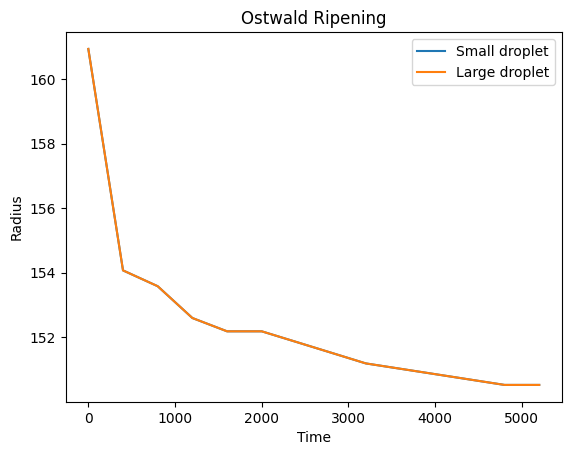

In [10]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.ndimage import label, sum as ndi_sum

# ------------- parameters -------------
threshold = 0.0     # phi > 0 is "inside" a droplet
dx = dy = (128*2*np.pi) / 128  # or whatever your grid spacing is
# ------------- helpers -------------

def get_sorted_phi_files(pattern="phi_*.npy"):
    """Return sorted list of filenames matching pattern."""
    files = sorted(glob.glob(pattern),
                   key=lambda fn: int(fn.split('_')[1].split('.npy')[0]))
    return files

def extract_two_radii(phi, threshold=0.0):
    """From a 2D phi field, threshold, label, and return the two largest radii."""
    mask = (phi > threshold)
    labeled, n = label(mask)
    if n < 2:
        return None
    areas = ndi_sum(mask, labeled, index=np.arange(1, n+1))
    radii = np.sqrt(areas * dx * dy / np.pi)
    # take the two largest
    radii = np.sort(radii)[-2:]
    return radii

# ------------- main analysis -------------

# 1) load all phi files
phi_files = get_sorted_phi_files("phi_*.npy")

times = []
small_r = []
large_r = []

# 2) loop over them
for i, fn in enumerate(phi_files):
    phi = np.load(fn)
    radii = extract_two_radii(phi, threshold=threshold)
    time = i * 20000 * 0.02  # e.g. iteration * tau
    times.append(time)
    if radii is None:
        small_r.append(np.nan)
        large_r.append(np.nan)
    else:
        small_r.append(radii[0])
        large_r.append(radii[1])

# 3) plot Fig 4(b)
plt.figure()
plt.plot(times, small_r, label="Small droplet")
plt.plot(times, large_r, label="Large droplet")
plt.xlabel("Time")
plt.ylabel("Radius")
plt.legend()
plt.title("Ostwald Ripening")
plt.savefig("fig4b_extracted.png", dpi=300)
plt.show()


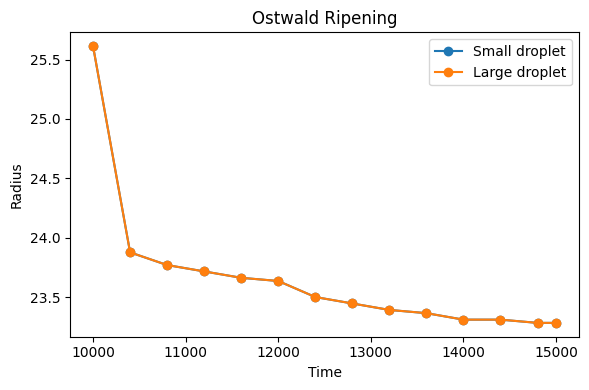

In [12]:
# radius_analysis.py

import numpy as np
import glob
from scipy.ndimage import label, sum as ndi_sum
import matplotlib.pyplot as plt

# -------------------- User-set parameters --------------------

# Domain and grid (must match your simulation)
s_start = -64.0
s_end   =  64.0
s_N     = 128      # number of grid points in x and y

# Time-stepping info (must match your simulation)
iterations_per_snapshot = 20000   # how many iterations between saved phi_*.npy
tau    = 0.02                    # time step size

# Threshold to detect “inside” the droplet
phi_threshold = 0.2

# ------------------------------------------------------------

# Compute grid spacing
dx = (s_end - s_start) / s_N
dy = dx

# Find and sort all phi_*.npy files by iteration index
phi_files = sorted(
    glob.glob("phi_*.npy"),
    key=lambda fn: int(fn.split('_')[1].split('.npy')[0])
)

times   = []
r_small = []
r_large = []

for fn in phi_files:
    # Load field
    phi = np.load(fn)

    # Threshold to binary mask
    mask = (phi > phi_threshold)

    # Label connected regions
    labeled, num_features = label(mask)

    # Extract areas of each region
    if num_features < 2:
        # Droplets have merged or vanished
        r_small.append(np.nan)
        r_large.append(np.nan)
    else:
        areas = ndi_sum(mask, labeled, index=np.arange(1, num_features+1))
        # Convert area to radius: A = π R^2 ⇒ R = sqrt(A/π)
        radii = np.sqrt(areas * dx * dy / np.pi)
        # Pick the two largest radii
        radii = np.sort(radii)[-2:]
        r_small.append(radii[0])
        r_large.append(radii[1])

    # Compute physical time of this snapshot
    iteration = int(fn.split('_')[1].split('.npy')[0])
    times.append(iteration * tau)

# Convert to arrays
times   = np.array(times)
r_small = np.array(r_small)
r_large = np.array(r_large)

# Plot Figure 4(b)
plt.figure(figsize=(6,4))
plt.plot(times, r_small, '-o', label='Small droplet')
plt.plot(times, r_large, '-o', label='Large droplet')
plt.xlabel('Time')
plt.ylabel('Radius')
plt.title('Ostwald Ripening')
plt.legend()
plt.tight_layout()
plt.savefig('fig4b_extracted.png', dpi=300)
plt.show()


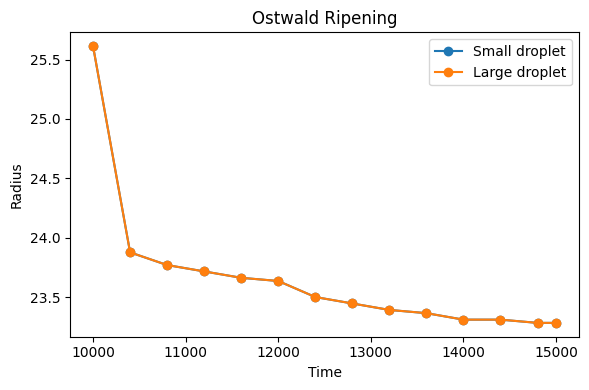

In [13]:
# radius_analysis.py

import numpy as np
import glob
from scipy.ndimage import label, sum as ndi_sum
import matplotlib.pyplot as plt

# -------------------- User-set parameters --------------------
s_start = -64.0
s_end   =  64.0
s_N     = 128

iterations_per_snapshot = 20000
tau    = 0.02
phi_threshold = 0.2

# ------------------------------------------------------------

dx = (s_end - s_start) / s_N

# Helper: sort files by iteration number
def sorted_phi_files():
    files = glob.glob("phi_*.npy")
    def keyfn(fn):
        i = int(fn.split("_")[1].split(".npy")[0])
        return i
    return sorted(files, key=keyfn)

# Analysis
phi_files = sorted_phi_files()
times   = []
r_small = []
r_large = []

for fn in phi_files:
    phi = np.load(fn)
    mask = (phi > phi_threshold)
    labeled, n = label(mask)
    if n < 2:
        r_small.append(np.nan)
        r_large.append(np.nan)
    else:
        areas = ndi_sum(mask, labeled, index=np.arange(1, n+1))
        radii = np.sqrt(areas * dx * dx / np.pi)
        radii = np.sort(radii)[-2:]
        r_small.append(radii[0])
        r_large.append(radii[1])

    iteration = int(fn.split("_")[1].split(".npy")[0])
    times.append(iteration * tau)

times   = np.array(times)
r_small = np.array(r_small)
r_large = np.array(r_large)

# Plot
plt.figure(figsize=(6,4))
plt.plot(times, r_small, '-o', label='Small droplet')
plt.plot(times, r_large, '-o', label='Large droplet')
plt.xlabel('Time')
plt.ylabel('Radius')
plt.title('Ostwald Ripening')
plt.legend()
plt.tight_layout()
plt.savefig('fig4b_fixed.png', dpi=300)
plt.show()


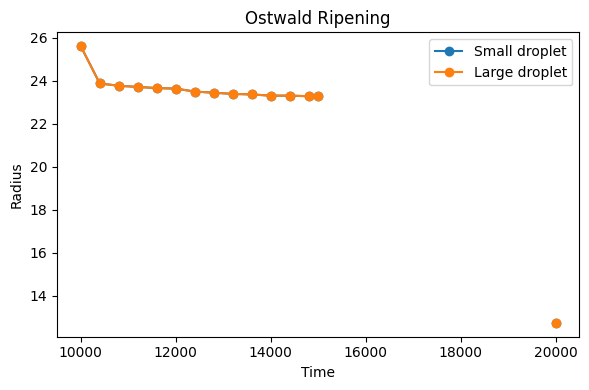

In [15]:
# radius_analysis.py

import numpy as np
import glob
from scipy.ndimage import label, sum as ndi_sum
import matplotlib.pyplot as plt

# -------------------- User‐set parameters --------------------

# Domain and grid parameters (must match your simulation)
s_start = -64.0
s_end   =  64.0
s_N     = 128      # number of grid points in x and y

# Time‐stepping info (must match your simulation)
iterations_per_snapshot = 20000   # you saved one phi_*.npy every 20000 iterations
tau    = 0.02                     # your time step size

# Threshold to define the “inside” of a droplet
phi_threshold = 0.2

# ------------------------------------------------------------

# Compute physical grid spacing
dx = (s_end - s_start) / s_N
dy = dx

# Helper to find and sort all phi snapshots by iteration number
def sorted_phi_files():
    files = glob.glob("phi_*.npy")
    def keyfn(fn):
        # assumes filenames like "phi_0.npy", "phi_20000.npy", etc.
        return int(fn.split("_")[1].split(".npy")[0])
    return sorted(files, key=keyfn)

# Main analysis
phi_files = sorted_phi_files()
times   = []
r_small = []
r_large = []

for fn in phi_files:
    # Load the field
    phi = np.load(fn)

    # Threshold to binary mask
    mask = (phi > phi_threshold)

    # Label connected regions
    labeled, num_features = label(mask)

    if num_features < 2:
        # if droplets have merged or one vanished
        r_small.append(np.nan)
        r_large.append(np.nan)
    else:
        # compute area of each region (in pixel count)
        areas = ndi_sum(mask, labeled, index=np.arange(1, num_features+1))
        # convert pixel count to area in physical units: area = count * dx*dy
        # then radius via A = π R^2
        radii = np.sqrt(areas * dx * dy / np.pi)
        # pick the two largest
        radii = np.sort(radii)[-2:]
        r_small.append(radii[0])
        r_large.append(radii[1])

    # compute the physical time of this snapshot
    iteration = int(fn.split("_")[1].split(".npy")[0])
    times.append(iteration * tau)

# convert to arrays for plotting
times   = np.array(times)
r_small = np.array(r_small)
r_large = np.array(r_large)

# Plot Figure 4(b)
plt.figure(figsize=(6,4))
plt.plot(times, r_small, '-o', label='Small droplet')
plt.plot(times, r_large, '-o', label='Large droplet')
plt.xlabel('Time')
plt.ylabel('Radius')
plt.title('Ostwald Ripening')
plt.legend()
plt.tight_layout()
plt.savefig('fig4b_extracted.png', dpi=300)
plt.show()


In [19]:
# fig4b_full.py

import os, sys
# Make sure the script’s directory is on Python’s path
sys.path.insert(0, os.path.dirname(__file__))

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, sum as ndi_sum

# Replace this with the actual filename of your solver module:
# e.g. if your file is AMB_plus.py:
from AMB_plus import solve_ambplus_2D


# --- Simulation parameters (match your solver defaults) ---
s_N     = 128          # grid size
s_start = -64.0        # domain min
s_end   =  64.0        # domain max

tau     = 0.02         # time step
t_len   = 1000         # total simulated time
eps_val = 1.0
a, b    = -0.25, 0.25
D, M    = 0.0, 1.0

# Choose (λ, ζ) for Region A or B:
lam, zet =  0.5, -1.0   # Region A (forward)
# lam, zet = -1.0, -4.0  # Region B (reverse)

# How often to collect a snapshot (in solver iterations)
snapshot_interval = 50

# ------------------------------------------------------------

# 1) Build a well-separated two-droplet initial condition
def make_two_droplet_ic(r_frac=0.05, sep_frac=0.8,
                        phi_inside=1.0, phi_outside=-0.9):
    L = s_end - s_start
    x = np.linspace(s_start, s_end, s_N, endpoint=False)
    y = np.linspace(s_start, s_end, s_N, endpoint=False)
    X, Y = np.meshgrid(x, y, indexing="ij")

    phi0 = phi_outside * np.ones((s_N, s_N))
    r   = r_frac * L
    sep = sep_frac * L

    mask1 = (X + sep/2)**2 + Y**2 < r**2
    mask2 = (X - sep/2)**2 + Y**2 < r**2
    phi0[mask1] = phi_inside
    phi0[mask2] = phi_inside
    return phi0

# 2) Run your solver in-memory, collecting snapshots
phi0 = make_two_droplet_ic()
snapshots = solve_ambplus_2D(
    phi_0            = phi0,
    s_N              = s_N,
    s_start          = s_start,
    s_end            = s_end,
    tau              = tau,
    t_len            = t_len,
    eps_val          = eps_val,
    a                = a,
    b                = b,
    lam_val          = lam,
    zeta             = zet,
    D                = D,
    M                = M,
    return_snapshots = True,
    snapshot_interval= snapshot_interval
)

# 3) Extract radii from each snapshot
dx = (s_end - s_start)/s_N
threshold = 0.2

times   = np.arange(len(snapshots)) * snapshot_interval * tau
r_small = []
r_large = []

for phi in snapshots:
    mask = (phi > threshold)
    labeled, num = label(mask)
    if num < 2:
        r_small.append(np.nan)
        r_large.append(np.nan)
    else:
        areas = ndi_sum(mask, labeled, index=np.arange(1, num+1))
        radii = np.sqrt(areas * dx*dx / np.pi)
        radii = np.sort(radii)[-2:]
        r_small.append(radii[0])
        r_large.append(radii[1])

r_small = np.array(r_small)
r_large = np.array(r_large)

# 4) Plot Figure 4(b)
plt.figure(figsize=(6,4))
plt.plot(times, r_small, '-o', label='Small droplet')
plt.plot(times, r_large, '-o', label='Large droplet')
plt.xlabel('Time')
plt.ylabel('Radius')
plt.title(f'Ostwald Ripening (λ={lam}, ζ={zet})')
plt.legend()
plt.tight_layout()
plt.savefig('fig4b_full.png', dpi=300)
plt.show()


NameError: name '__file__' is not defined